In [1]:
%%capture
from tqdm import tqdm_notebook as tqdm

import pandas as pd

import time
t1 = time.time()

import os
import numpy as np

from pandas import ExcelWriter
from pandas import ExcelFile

from datetime import datetime

from matplotlib import cm
from pylab import rcParams
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
import scipy.interpolate as spi
from scipy.interpolate import splrep, splev
import scipy.cluster.hierarchy as spc

import scipy.io
import math

from sklearn import metrics

In [2]:
#loading the files
file_dir = os.path.join('/Users/digisha/Downloads/Fatigue_project')
file_name = os.path.join(file_dir, 'All_patients_VAS_and_Sleep_diary_data_100819.xlsx')
df = pd.read_excel(file_name, sheetname = "Sheet1")

#df = pd.read_excel(file_with_data, sheetname=sheet_with_data)

/Applications/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


In [3]:
#changing datatypes - convering timestamp string to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])
#drop not required coloumn
df = df.drop(['guid', 'other', 'is_checked'], axis=1)

df = df[df['question_id'].isin([1600, 1601, 1602, 1603])]

#only depression fatigue questionnare considererd - dropping th experiment patient
df = df.loc[df['subject_id'] != 99998].reset_index(drop=True)
df.head()

with tqdm(total= len(df)) as pbar:
    for i in range(0,len(df)):
        if df['subject_id'][i] == 610:
            df['subject_id'][i] = 61
        elif df['subject_id'][i] == 600:
            df['subject_id'][i] = 60
        elif df['subject_id'][i] == 599:
            df['subject_id'][i] = 59
        pbar.update(1)
        
df.head(5)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,subject_id,question_id,answer,timestamp
0,63,1600,7,2019-09-08 20:51:56
1,63,1601,3,2019-09-08 20:52:06
2,63,1602,5,2019-09-08 20:52:13
3,63,1603,1,2019-09-08 20:52:20
4,63,1600,6,2019-09-08 21:45:02


In [4]:
# to check if there is a patient with less than 2 readings- as for interpolating we need atleast 2 reading 
#and will have to drop such patients

#list of patients id
UniqueNames = df.subject_id.unique()

#list of question_id
qid = df.question_id.unique()

#list of patients with less than 2 readings
l1 = []

with tqdm(total= (len(UniqueNames)*len(qid))) as pbar:
    for q in qid:
        for pat in UniqueNames:
            count = 0
            for i in range(0,len(df)):
                if q == df['question_id'][i]:
                    count += 1
            if count <= 1:
                print(pat)
                l1.append(pat)
            
            pbar.update(1)
print(l1)


[]


In [5]:
#changing the datatype of answer column to integer
df['answer']=df.answer.astype('int64')

# date column added to know if the questionnaire is a part of the same day or the next
df['date'] = [d.date() for d in df['timestamp']]

#initiating a datetime obeject as zero time for offset time
datetime_object = datetime.strptime('00:00:00', '%H:%M:%S')

#creating 3 more coloums to get hour, time and day of the data row
df['hour'] = 0.00
df['time'] = 0
df['day'] = 0

#changing the datatype of anwer column to float
df['time'] = df['time'].astype('float')

initial = 0

# This may take a while
with tqdm(total= (len(UniqueNames)*len(qid))) as pbar:
    for q in qid:
        for pat in UniqueNames:
            count = 0
            for i in range(0,len(df)):
                if q == df['question_id'][i]:
                    if pat == df['subject_id'][i]:
                        hour = ((df['timestamp'][i] - datetime_object).seconds/(60*60))
                        if count == 0:
                            hour = ((df['timestamp'][i] - datetime_object).seconds/(60*60))
                            df['time'][i] = hour/24
                            df['day'][i] = 0
                            count+= 1
                            initial = i
                        else:
                            df['time'][i] = (df['timestamp'][i] - df['timestamp'][initial]).days + (hour/24)
                            df['day'][i] = (df['timestamp'][i] - df['timestamp'][initial]).days
            pbar.update(1)

df['time'] = df['time'].round(3)
#df = df.sort_values(['subject_id', 'time'], ascending=[True, True])

df.head(7)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to 

,subject_id,question_id,answer,timestamp,date,hour,time,day
0,63,1600,7,2019-09-08 20:51:56,2019-09-08,0.0,0.869,0
1,63,1601,3,2019-09-08 20:52:06,2019-09-08,0.0,0.870,0
2,63,1602,5,2019-09-08 20:52:13,2019-09-08,0.0,0.870,0
3,63,1603,1,2019-09-08 20:52:20,2019-09-08,0.0,0.870,0
4,63,1600,6,2019-09-08 21:45:02,2019-09-08,0.0,0.906,0
5,63,1601,3,2019-09-08 21:45:11,2019-09-08,0.0,0.906,0
6,63,1602,7,2019-09-08 21:45:20,2019-09-08,0.0,0.906,0


In [6]:
#new data frames created for each question_id and not required coloumns were dropped
mask = (df['question_id'] == 1600)
df_00 = df.loc[mask].reset_index(drop=True)
df_00 = df_00.drop(['timestamp', 'hour', 'date', "question_id"], axis=1)

mask = (df['question_id'] == 1601)
df_01 = df.loc[mask].reset_index(drop=True)
df_01 = df_01.drop(['timestamp', 'hour', 'date', "question_id"], axis=1)

mask = (df['question_id'] == 1602)
df_02 = df.loc[mask].reset_index(drop=True)
df_02 = df_02.drop(['timestamp', 'hour', 'date', "question_id"], axis=1)

mask = (df['question_id'] == 1603)
df_03 = df.loc[mask].reset_index(drop=True)
df_03 = df_03.drop(['timestamp', 'hour', 'date', "question_id"], axis=1)

In [7]:
#create a data frame dictionary to store your data frames with keys as subject_id
DataFrameDict = {elem : pd.DataFrame for elem in UniqueNames}
Dict = {elem : pd.DataFrame for elem in UniqueNames}

In [8]:
# Utility Functions - to plot trajectories

color_lst = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_lst.extend(['firebrick', 'olive', 'indigo', 'khaki', 'teal', 'saddlebrown', 
                 'skyblue', 'coral', 'darkorange', 'lime', 'darkorchid', 'dimgray'])

def plot_cluster(traj_lst, cluster_lst):
    '''
    Plots given trajectories with a color that is specific for every trajectory's own cluster index.
    Outlier trajectories which are specified with -1 in `cluster_lst` are plotted dashed with black color
    '''
    cluster_count = np.max(cluster_lst) + 1
    
    for traj, cluster in zip(traj_lst, cluster_lst):
        
        if cluster == -1:
            #pass
            # Means it it a noisy trajectory, paint it black
            plt.plot(traj[:, 0], traj[:, 1], c='k', linestyle='dashed')
        
        else:
            plt.plot(traj[:, 0], traj[:, 1], c=color_lst[cluster % len(color_lst)])
    plt.show()

# Some visualization stuff, not so important
sns.set()
plt.rcParams['figure.figsize'] = (24, 12)

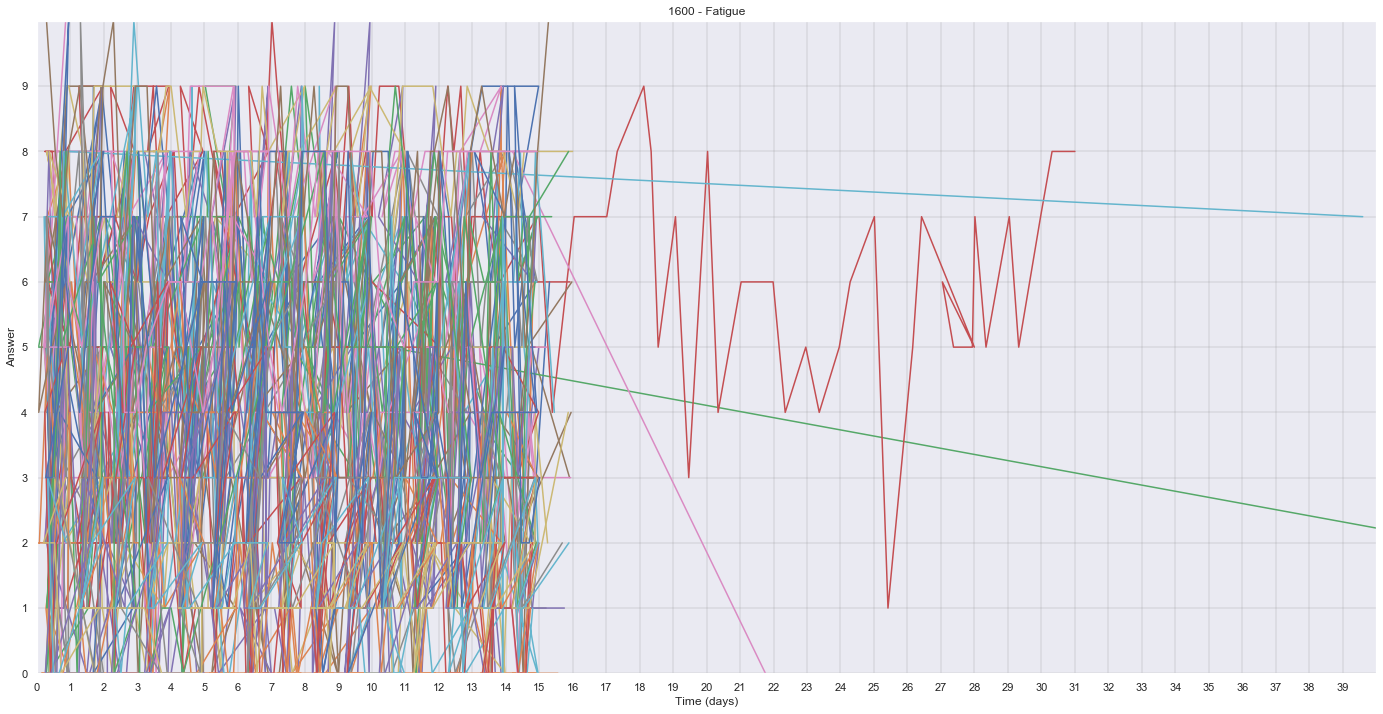

In [9]:
#plotting the interpolated data for fatique

for key in DataFrameDict.keys():
    DataFrameDict[key] = df_00[:][df_00.subject_id == key]

#original data
traj_lst1 = []

#answer array
yt1 = []

#interpolated data
interpolated_data1 = []

with tqdm(total=len(UniqueNames)) as pbar:
    for key in UniqueNames:
        x = DataFrameDict[key]['time'].values
        y = DataFrameDict[key]['answer'].values
        np.set_printoptions(formatter={'float_kind':'{:0.3f}'.format})
        xnew = np.arange(0,13,1/4)
        intfunc = spi.interp1d(x,y,kind = 'linear', fill_value=(y.min(), y.max()), bounds_error=False)
        ynew = intfunc(xnew)
        xnew = xnew.round(3)
        ynew = ynew.round(3)
        X = np.array(list(zip(x, y)))
        traj_lst1.append(X)
        
        Xnew = np.array(list(zip(xnew, ynew))) #interpolated data
        interpolated_data1.append(Xnew)
        
        yt1.append(ynew)
        pbar.update(1)

for traj in traj_lst1:
    plt.plot(traj[:, 0], traj[:, 1])
    
plt.ylim(0, 10)
plt.xlim(0, 40)
plt.yticks(np.arange(0, 10, 1))
plt.xticks(np.arange(0, 40, 1))
plt.xlabel('Time (days)')
plt.ylabel('Answer')
plt.title('1600 - Fatigue')
plt.grid(color='grey', linestyle='-', linewidth=0.25)

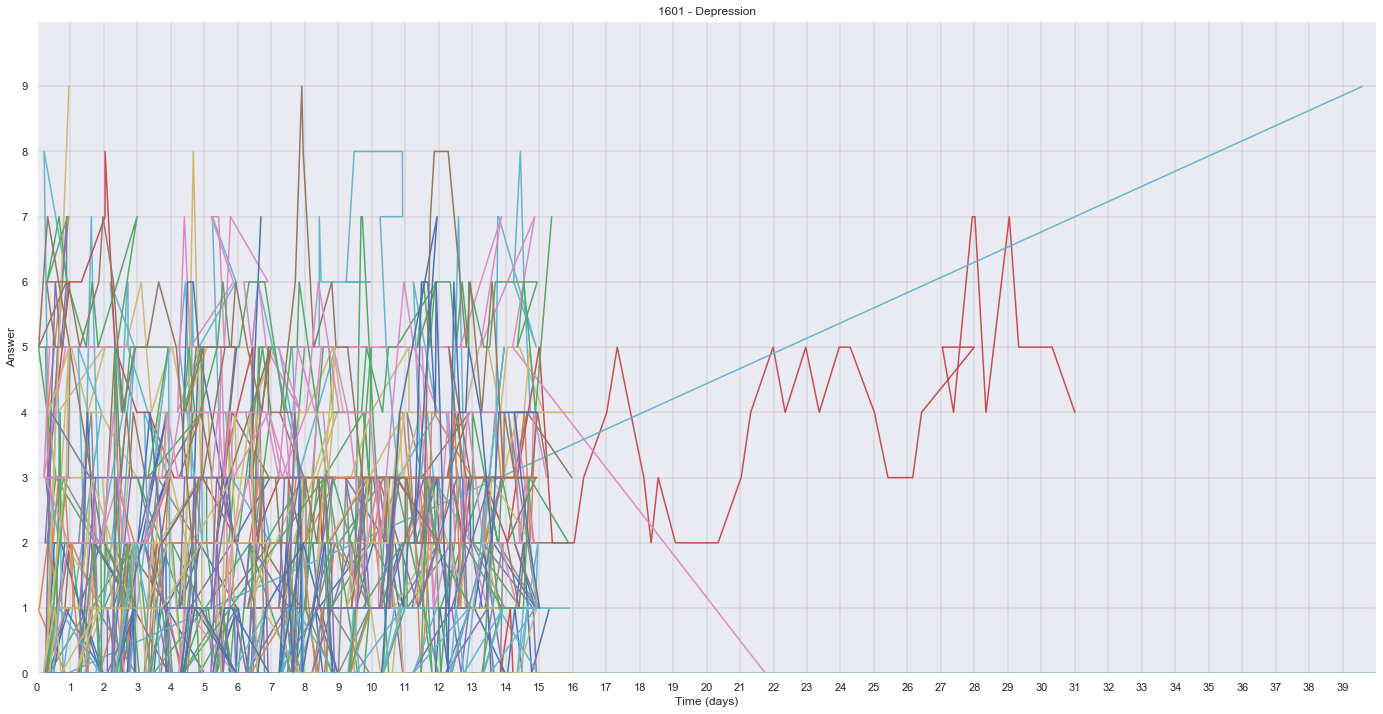

In [10]:
#plotting the interpolated data for Depression
for key in DataFrameDict.keys():
    DataFrameDict[key] = df_01[:][df_01.subject_id == key]

#original data
traj_lst2 = []

#answer array
yt2 = []

#interpolated data
interpolated_data2 = []

with tqdm(total= len(UniqueNames)) as pbar:
    for key in UniqueNames:
        #print(DataFrameDict[key])
        x = DataFrameDict[key]['time'].values
        y = DataFrameDict[key]['answer'].values
        np.set_printoptions(formatter={'float_kind':'{:0.3f}'.format})
        xnew = np.arange(0,13,1/4)
        intfunc = spi.interp1d(x,y,kind = 'linear', fill_value=(y.min(), y.max()), bounds_error=False)
        ynew = intfunc(xnew)
        xnew = xnew.round(3)
        ynew = ynew.round(3)
        
        X = np.array(list(zip(x, y)))
        traj_lst2.append(X)
        
        Xnew = np.array(list(zip(xnew, ynew))) #interpolated data
        interpolated_data2.append(Xnew)
        
        yt2.append(ynew)
        pbar.update(1)

for traj in traj_lst2:
    plt.plot(traj[:, 0], traj[:, 1])
    
plt.ylim(0, 10)
plt.xlim(0, 40)
plt.yticks(np.arange(0, 10, 1))
plt.xticks(np.arange(0, 40, 1))
plt.xlabel('Time (days)')
plt.ylabel('Answer')
plt.title('1601 - Depression')
plt.grid(color='grey', linestyle='-', linewidth=0.25)

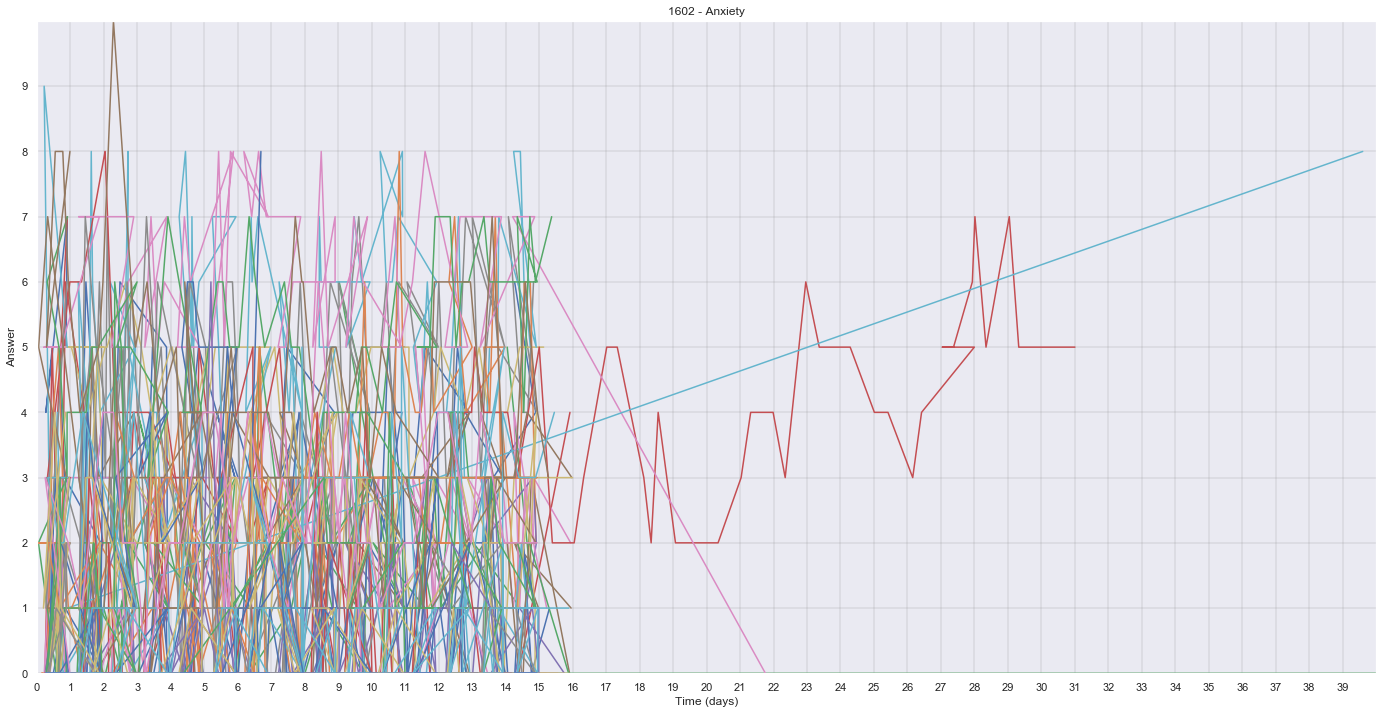

In [11]:
#plotting the interpolated data for Anxiety
for key in DataFrameDict.keys():
    DataFrameDict[key] = df_02[:][df_02.subject_id == key]

#original data
traj_lst3 = []

#answer array
yt3 = []

#interpolated data
interpolated_data3 = []

with tqdm(total= len(UniqueNames)) as pbar:
    for key in UniqueNames:
        #print(DataFrameDict[key])
        x = DataFrameDict[key]['time'].values
        y = DataFrameDict[key]['answer'].values
        np.set_printoptions(formatter={'float_kind':'{:0.3f}'.format})
        xnew = np.arange(0,13,1/4)
        intfunc = spi.interp1d(x,y,kind = 'linear', fill_value=(y.min(), y.max()), bounds_error=False)
        ynew = intfunc(xnew)
        xnew = xnew.round(3)
        ynew = ynew.round(3)
        X = np.array(list(zip(x, y)))
        traj_lst3.append(X)
        
        Xnew = np.array(list(zip(xnew, ynew))) #interpolated data
        interpolated_data3.append(Xnew)
        
        yt3.append(ynew)
        pbar.update(1)

for traj in traj_lst3:
    plt.plot(traj[:, 0], traj[:, 1])
    
plt.ylim(0, 10)
plt.xlim(0, 40)
plt.yticks(np.arange(0, 10, 1))
plt.xticks(np.arange(0, 40, 1))
plt.xlabel('Time (days)')
plt.ylabel('Answer')
plt.title('1602 - Anxiety')
plt.grid(color='grey', linestyle='-', linewidth=0.25)

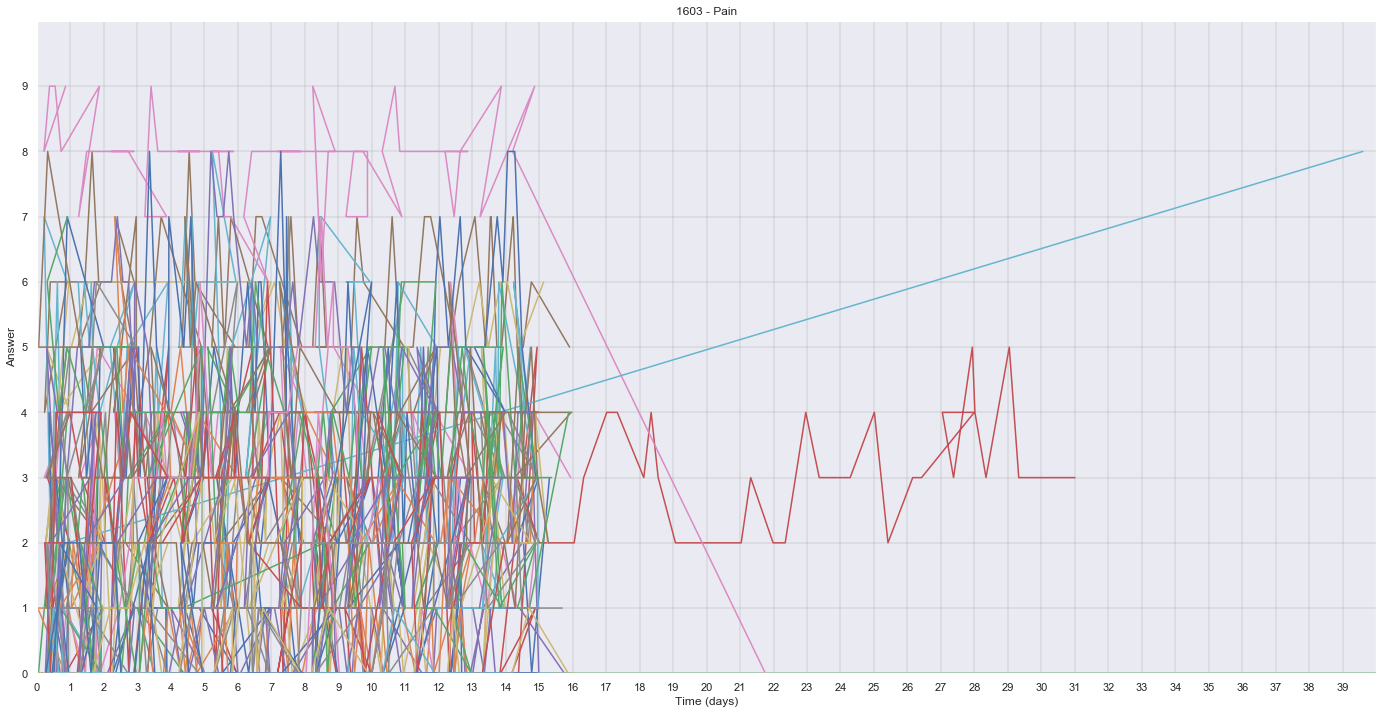

In [12]:
#plotting the interpolated data for Pain
for key in DataFrameDict.keys():
    DataFrameDict[key] = df_03[:][df_03.subject_id == key]

#original data
traj_lst4 = []

#answer array
yt4 = []

#interpolated data
interpolated_data4 = []

with tqdm(total= len(UniqueNames)) as pbar:
    for key in UniqueNames:
        #print(DataFrameDict[key])
        x = DataFrameDict[key]['time'].values
        y = DataFrameDict[key]['answer'].values
        np.set_printoptions(formatter={'float_kind':'{:0.3f}'.format})
        xnew = np.arange(0,13,1/4)
        intfunc = spi.interp1d(x,y,kind = 'linear', fill_value=(y.min(), y.max()), bounds_error=False)
        ynew = intfunc(xnew)
        xnew = xnew.round(3)
        ynew = ynew.round(3)
        
        X = np.array(list(zip(x, y))) #original data
        traj_lst4.append(X)
    
        Xnew = np.array(list(zip(xnew, ynew))) #interpolated data
        interpolated_data4.append(Xnew)
        
        yt4.append(ynew)
        pbar.update(1)

for traj in traj_lst4:
    plt.plot(traj[:, 0], traj[:, 1])
    
plt.ylim(0, 10)
plt.xlim(0, 40)
plt.yticks(np.arange(0, 10, 1))
plt.xticks(np.arange(0, 40, 1))
plt.xlabel('Time (days)')
plt.ylabel('Answer')
plt.title('1603 - Pain')
plt.grid(color='grey', linestyle='-', linewidth=0.25)

In [13]:
# array with a matrix(each row indicating trajectory for each question_id - fatigue, depression, anxiety and pain)
#for each patient
X = np.array(list(zip(yt1, yt2, yt3, yt4)))

interpolated_data = np.array(list(zip(interpolated_data1, interpolated_data2, interpolated_data3, interpolated_data4)))

In [14]:
#X[1]

#interpolated_data

In [15]:
#function for calculating correration between matrices of 2 different patients 
#and pdist(correlation distance using Statistical Process Control python package) 

def corr_dist(T1, T2):
    # pearson Correlation coefficient using matrix correlation formula
    numerator = np.mean((T1 - T1.mean()) * (T2 - T2.mean()))
    denominator = T1.std() * T2.std()
    if denominator == 0:
        return 0
    else:
        correlation = numerator / denominator
    #converting correlation to correlation matrix format to calculate pdist
    corr_matrix = np.zeros((2, 2))
    corr_matrix[0,0] = correlation
    corr_matrix[1,1] = correlation
    #converting correlation to distance        
    pdist = spc.distance.pdist(corr_matrix)
    #to bypass NaN data
    if math.isnan(pdist):
            pdist = 0
    if math.isnan(correlation):
            correlation = 0.00
    return correlation,pdist

In [16]:
#calculating a correlation matrix with correlation value between 2 subjects
#calculating a distance matrix with correlation-distance value between 2 subjects

traj_count = len(UniqueNames)
D = np.zeros((traj_count, traj_count))
corr_matrix = np.zeros((traj_count, traj_count))

cluster = []

# This may take a while
for i in range(0, traj_count):
    for j in range(0, traj_count):
        #print(i,j)yt[u]
        corr, distance = corr_dist(X[i], X[j])
        #print (corr.round(3), distance)
        D[i, j] = distance
        corr_matrix[i, j] = corr

linkage = spc.linkage(D, method='complete')       
clust = spc.fcluster(linkage, t= 5, criterion= "maxclust")

clusters_14day = np.array(list(zip(UniqueNames, clust)))
#corr_matrix

In [17]:
#heatmap for correlation between patient pairs
%matplotlib qt
plt.rcParams['figure.figsize'] = (6, 6)
xticks = np.arange(42+1)
ax = sns.heatmap(
    corr_matrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=20),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=70,
    horizontalalignment='left'
);
plt.title('Correlation heatmap between patient pairs')

plt.tight_layout()

In [18]:
#printing a list of patient_id and cluster_id
print(clusters_14day)

[[63  1]
 [64  5]
 [ 1  1]
 [ 3  1]
 [ 2  1]
 [ 5  3]
 [ 4  3]
 [ 6  2]
 [ 8  3]
 [ 9  5]
 [11  1]
 [12  1]
 [13  1]
 [ 7  1]
 [14  1]
 [15  2]
 [16  3]
 [17  4]
 [18  5]
 [19  1]
 [20  2]
 [22  5]
 [23  2]
 [24  2]
 [25  2]
 [26  2]
 [27  1]
 [29  1]
 [30  1]
 [31  1]
 [34  5]
 [35  2]
 [36  4]
 [37  1]
 [40  3]
 [41  3]
 [39  2]
 [43  3]
 [45  5]
 [47  1]
 [48  1]
 [50  1]
 [52  1]
 [53  2]
 [54  3]
 [55  4]
 [57  1]
 [56  1]
 [59  4]
 [60  1]
 [61  1]]


In [19]:
#cluster_df = pd.DataFrame(columns=['subject_id'=UniqueNames, 'cluster_id' = 99])

cluster_df = pd.DataFrame(clusters_14day, columns = ['subject_id', 'cluster_id'])

In [20]:
cluster_df.head()

,subject_id,cluster_id
0,63,1
1,64,5
2,1,1
3,3,1
4,2,1


In [21]:
cluster_names = cluster_df.cluster_id.unique()

DataFrameDict = {elem : pd.DataFrame for elem in cluster_names}

for key in DataFrameDict.keys():
    y = []
    for i in range(len(cluster_df)):
        if key == cluster_df['cluster_id'][i]:
            y.append(cluster_df["subject_id"][i])
    DataFrameDict[key] = y

DataFrameDict

{1: [63,
  1,
  3,
  2,
  11,
  12,
  13,
  7,
  14,
  19,
  27,
  29,
  30,
  31,
  37,
  47,
  48,
  50,
  52,
  57,
  56,
  60,
  61],
 5: [64, 9, 18, 22, 34, 45],
 3: [5, 4, 8, 16, 40, 41, 43, 54],
 2: [6, 15, 20, 23, 24, 25, 26, 35, 39, 53],
 4: [17, 36, 55, 59]}

In [22]:
def corr_dist_1d(u, v):
    #d = (np.corrcoef(yt[u], yt[v])[0])[1].round(3)
    corr_matrix = np.corrcoef(u, v)
    corr = corr_matrix[1][0]

    if math.isnan(corr):
            corr = 0.00
            
    #corr = corr.astype(float).round(3) #.round(3).astype(float)
    #return d
    return corr

In [23]:
#Cat_id - 0 = fatigue, 1 = depression, 2 = anxiety, 3 = pain
def corr_martix(cluster_id,cat_id):
    
    SubjectData =  np.array(list(zip(UniqueNames,X)))
    SubjectInCluster = []
    for i in DataFrameDict[cluster_id]:
        for j in range(len(SubjectData)):
            if i == SubjectData[j][0]:
                SubjectInCluster.append(SubjectData[j][1])

    traj_count = len(DataFrameDict[cluster_id])
    corr_matrix = np.zeros((traj_count, traj_count))
    
    for i in range(0, traj_count):
        for j in range(0, traj_count):
            corr = corr_dist_1d(SubjectInCluster[i][cat_id], SubjectInCluster[j][cat_id])
            corr_matrix[i, j] = corr
    return corr_matrix

In [24]:
def heatmap(data,title):
    
    plt.title(title)
    plt.tight_layout()
    ax = sns.heatmap(
        data, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=20),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=70,
        horizontalalignment='left'
    );

In [25]:
plt.rcParams['figure.figsize'] = (24, 24)

plt.subplot(2, 2, 1)
heatmap(corr_martix(1,0),'fatigue Heatmap')
plt.subplot(2, 2, 2)
heatmap(corr_martix(1,1),'Depression Heatmap')
plt.subplot(2, 2, 3)
heatmap(corr_martix(1,2),'Anxiety heatmap')
plt.subplot(2, 2, 4)
heatmap(corr_martix(1,3),'Pain heatmap')


plt.tight_layout()

/Applications/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Applications/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [28]:
def heatmap_subplot(cluster_id):
    plt.rcParams['figure.figsize'] = (24, 24)
    #cluster_id = 2
    plt.subplot(2, 2, 1)
    heatmap(corr_martix(cluster_id,0),'fatigue Heatmap_c2')
    plt.subplot(2, 2, 2)
    heatmap(corr_martix(cluster_id,1),'Depression Heatmap_c2')
    plt.subplot(2, 2, 3)
    heatmap(corr_martix(cluster_id,2),'Anxiety heatmap_c2')
    plt.subplot(2, 2, 4)
    heatmap(corr_martix(cluster_id,3),'Pain heatmap_c2')


    plt.tight_layout()

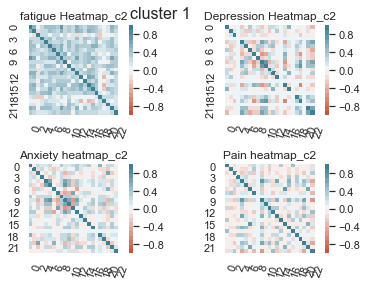

In [29]:
%matplotlib inline
plt.suptitle("cluster 1", fontsize=16)
heatmap_subplot(1)

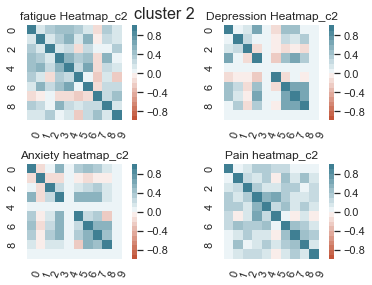

In [30]:
%matplotlib inline
plt.suptitle("cluster 2", fontsize=16)
heatmap_subplot(2)

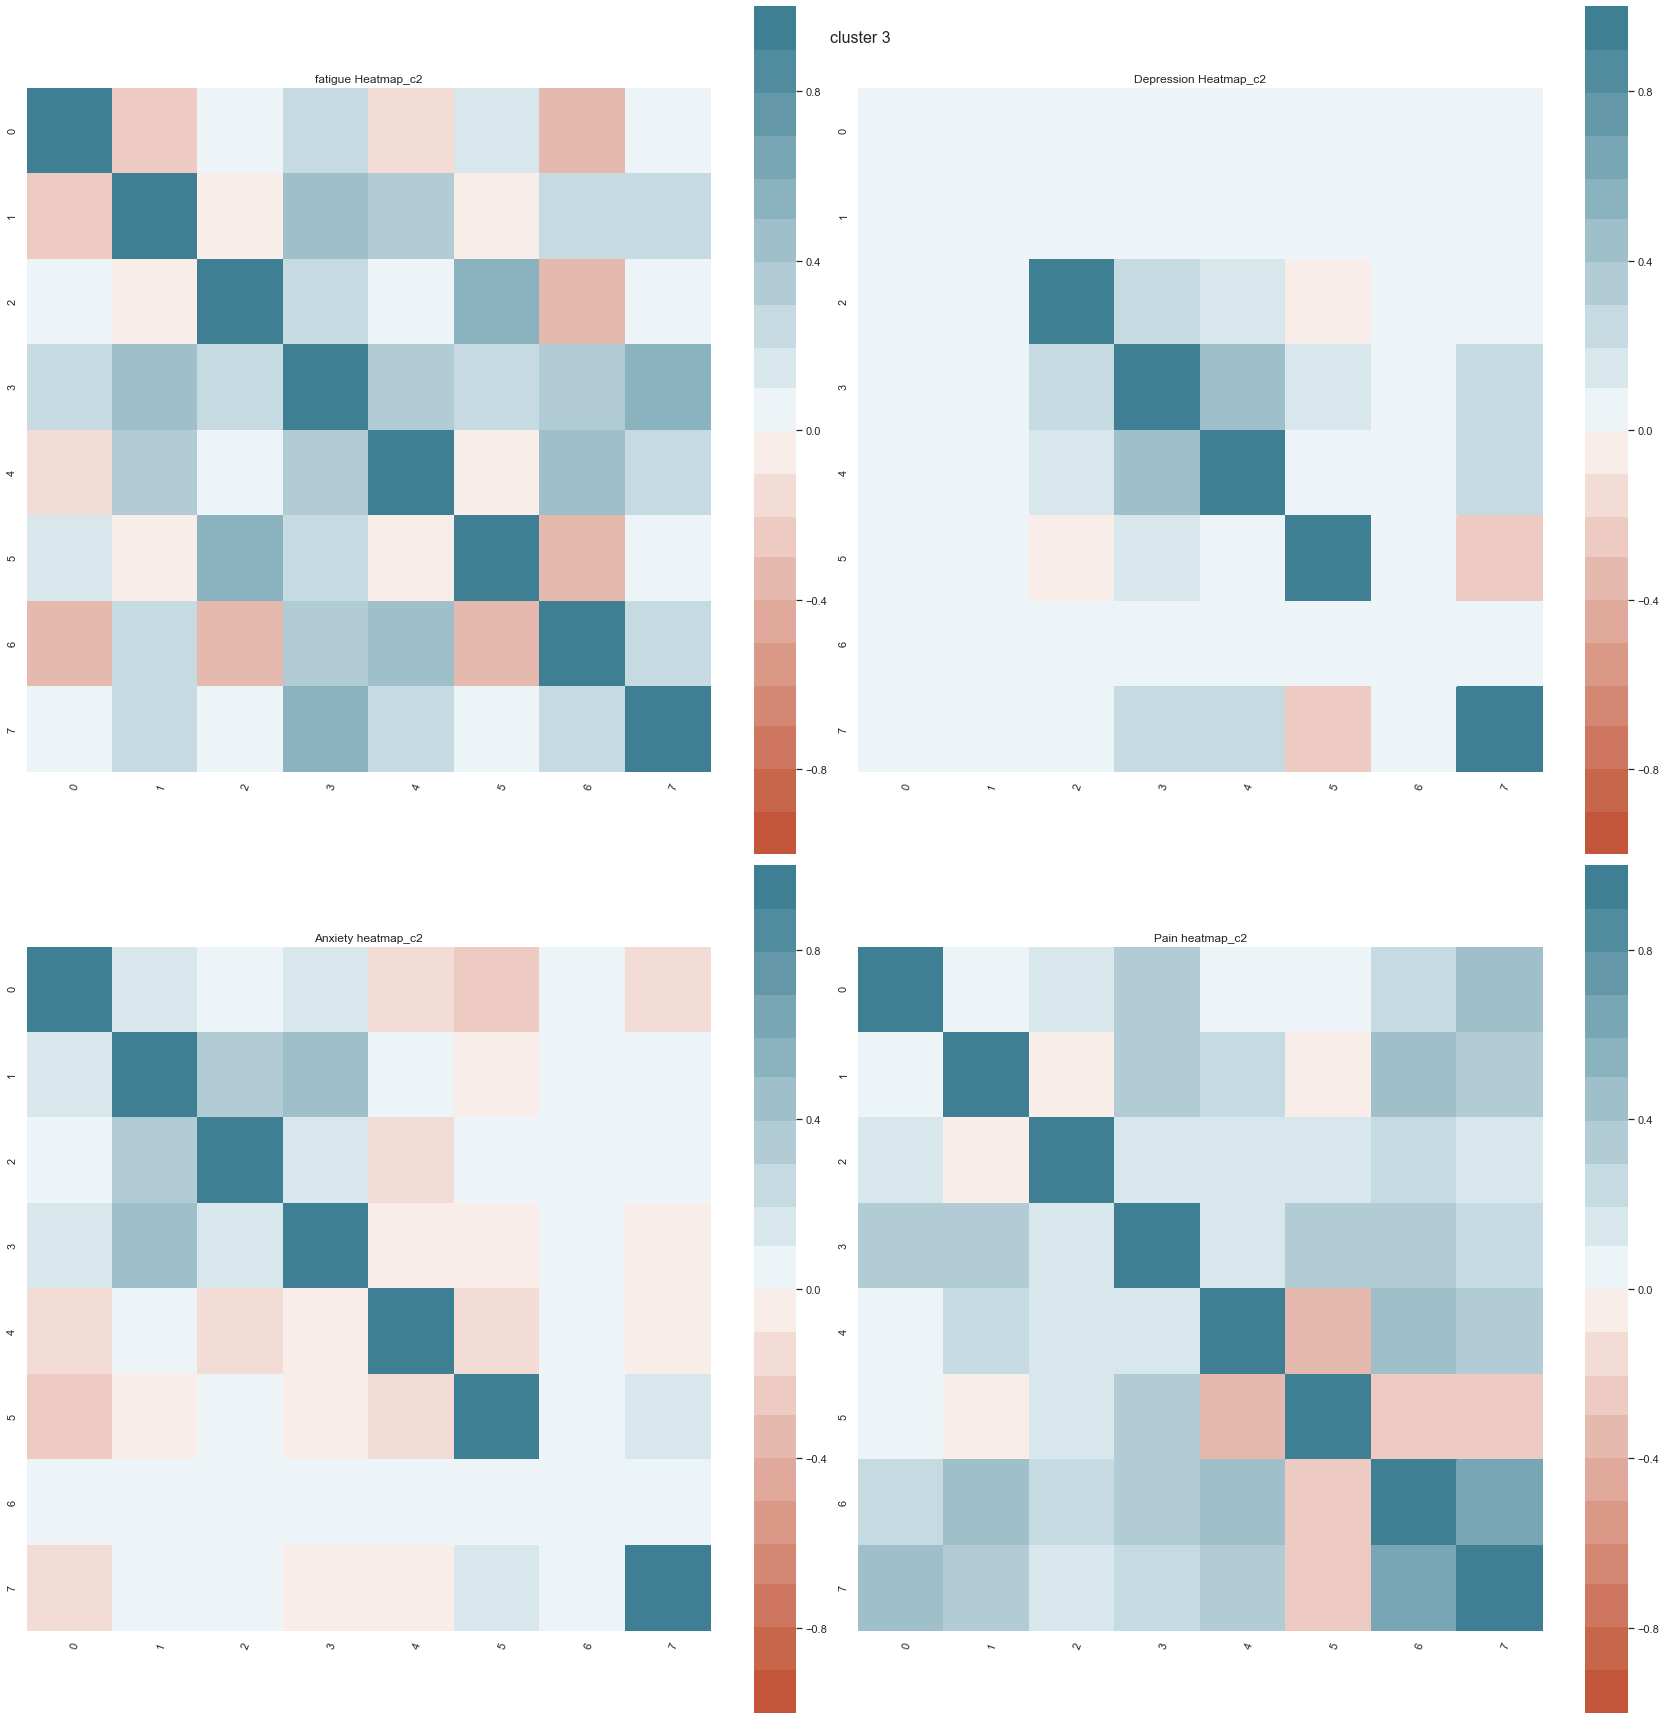

In [31]:
plt.suptitle("cluster 3", fontsize=16)
heatmap_subplot(3)

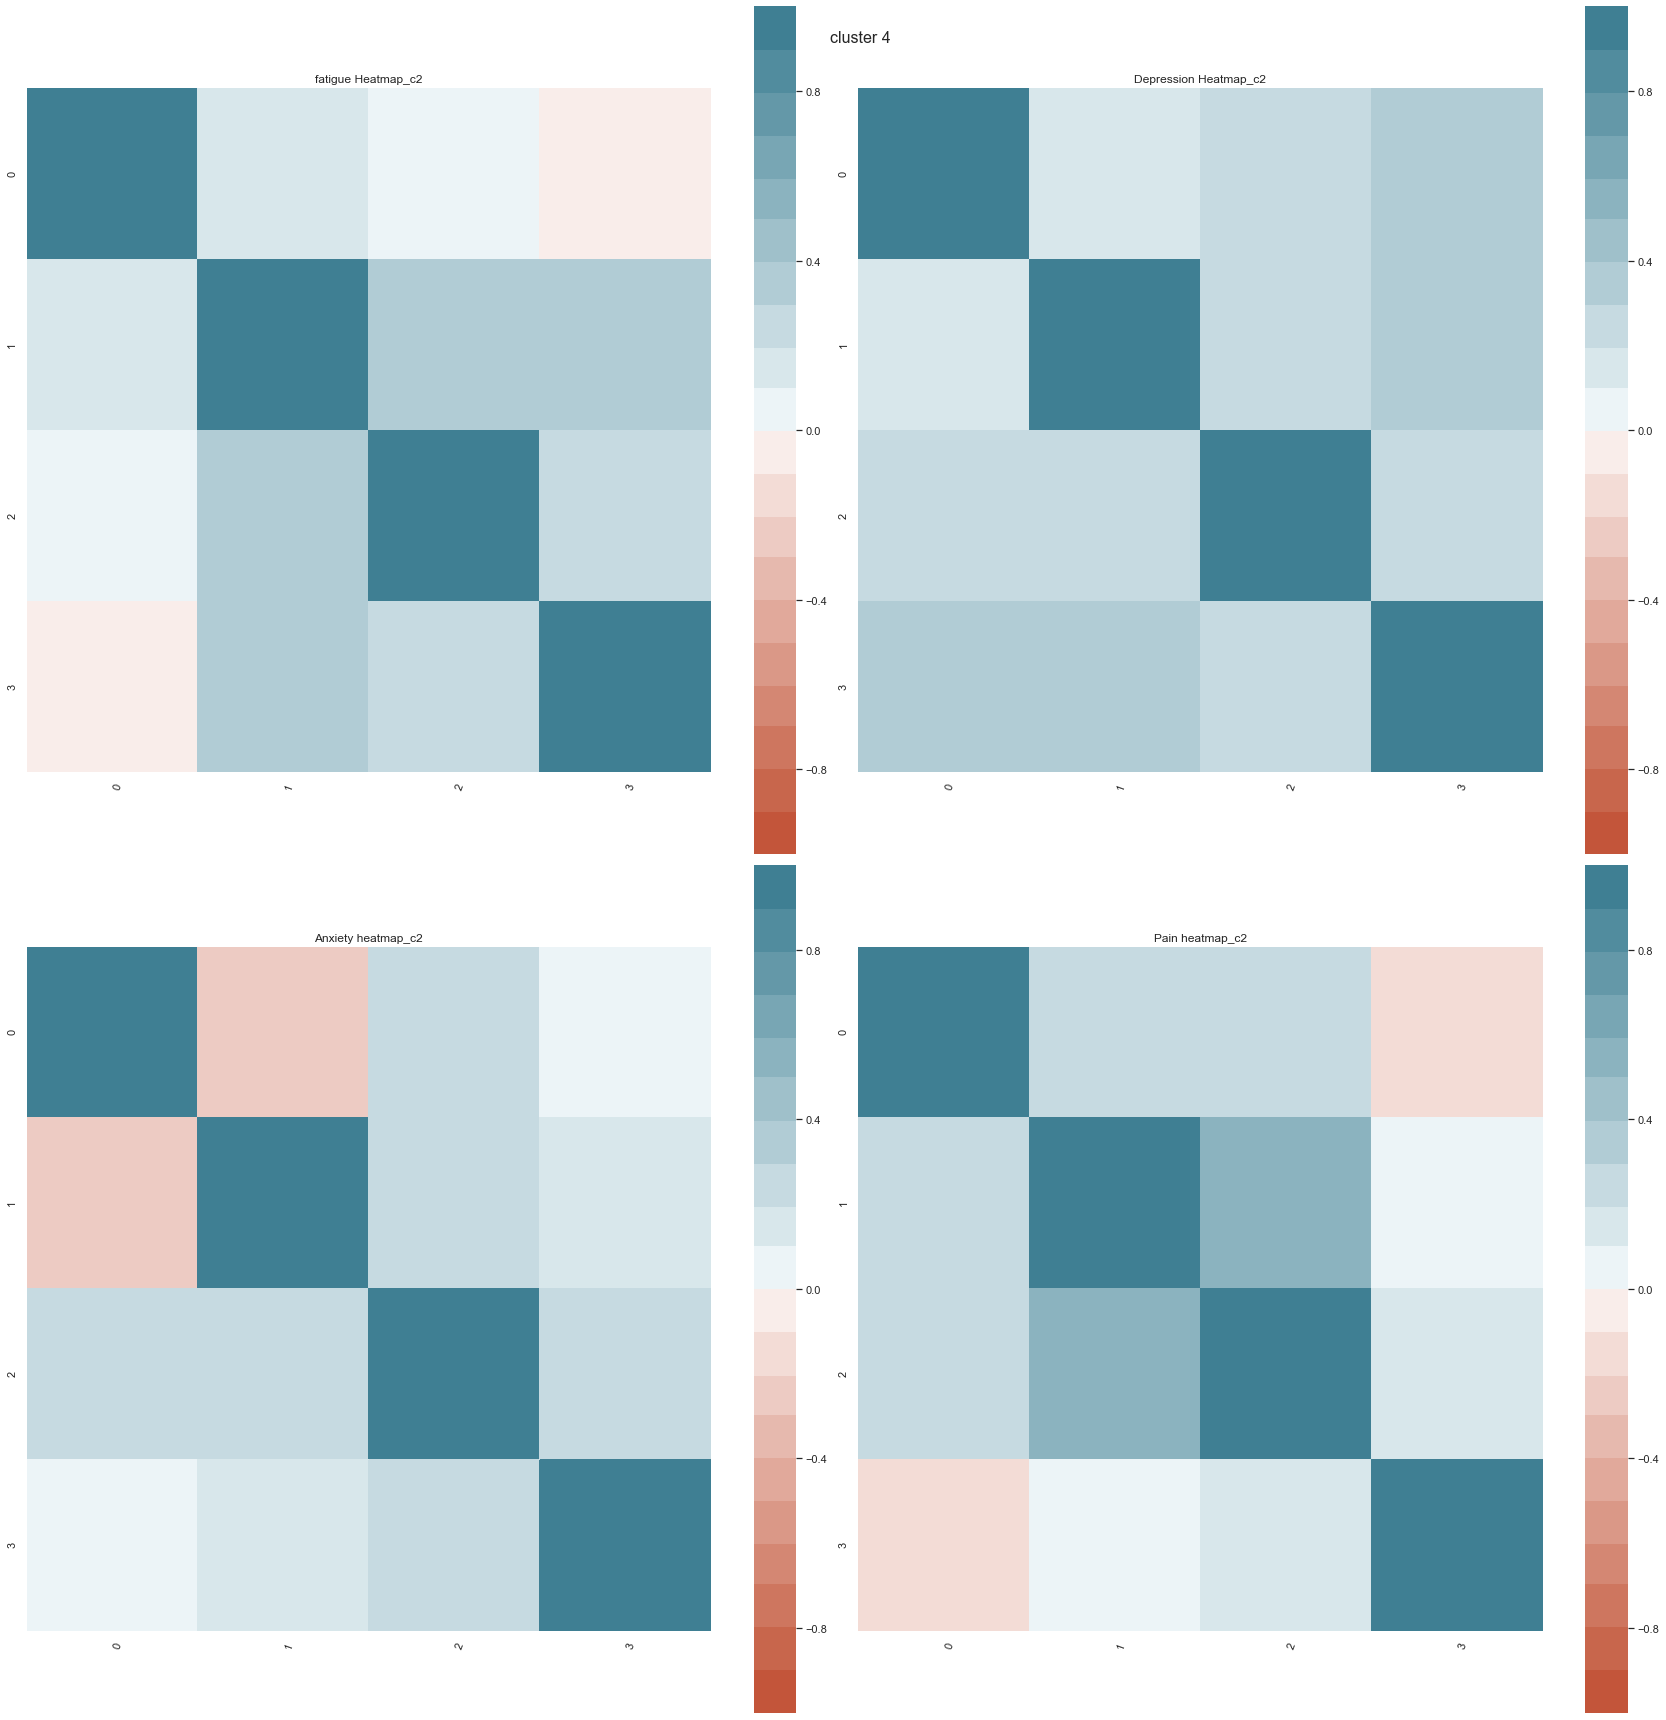

In [32]:
plt.suptitle("cluster 4", fontsize=16)
heatmap_subplot(4)

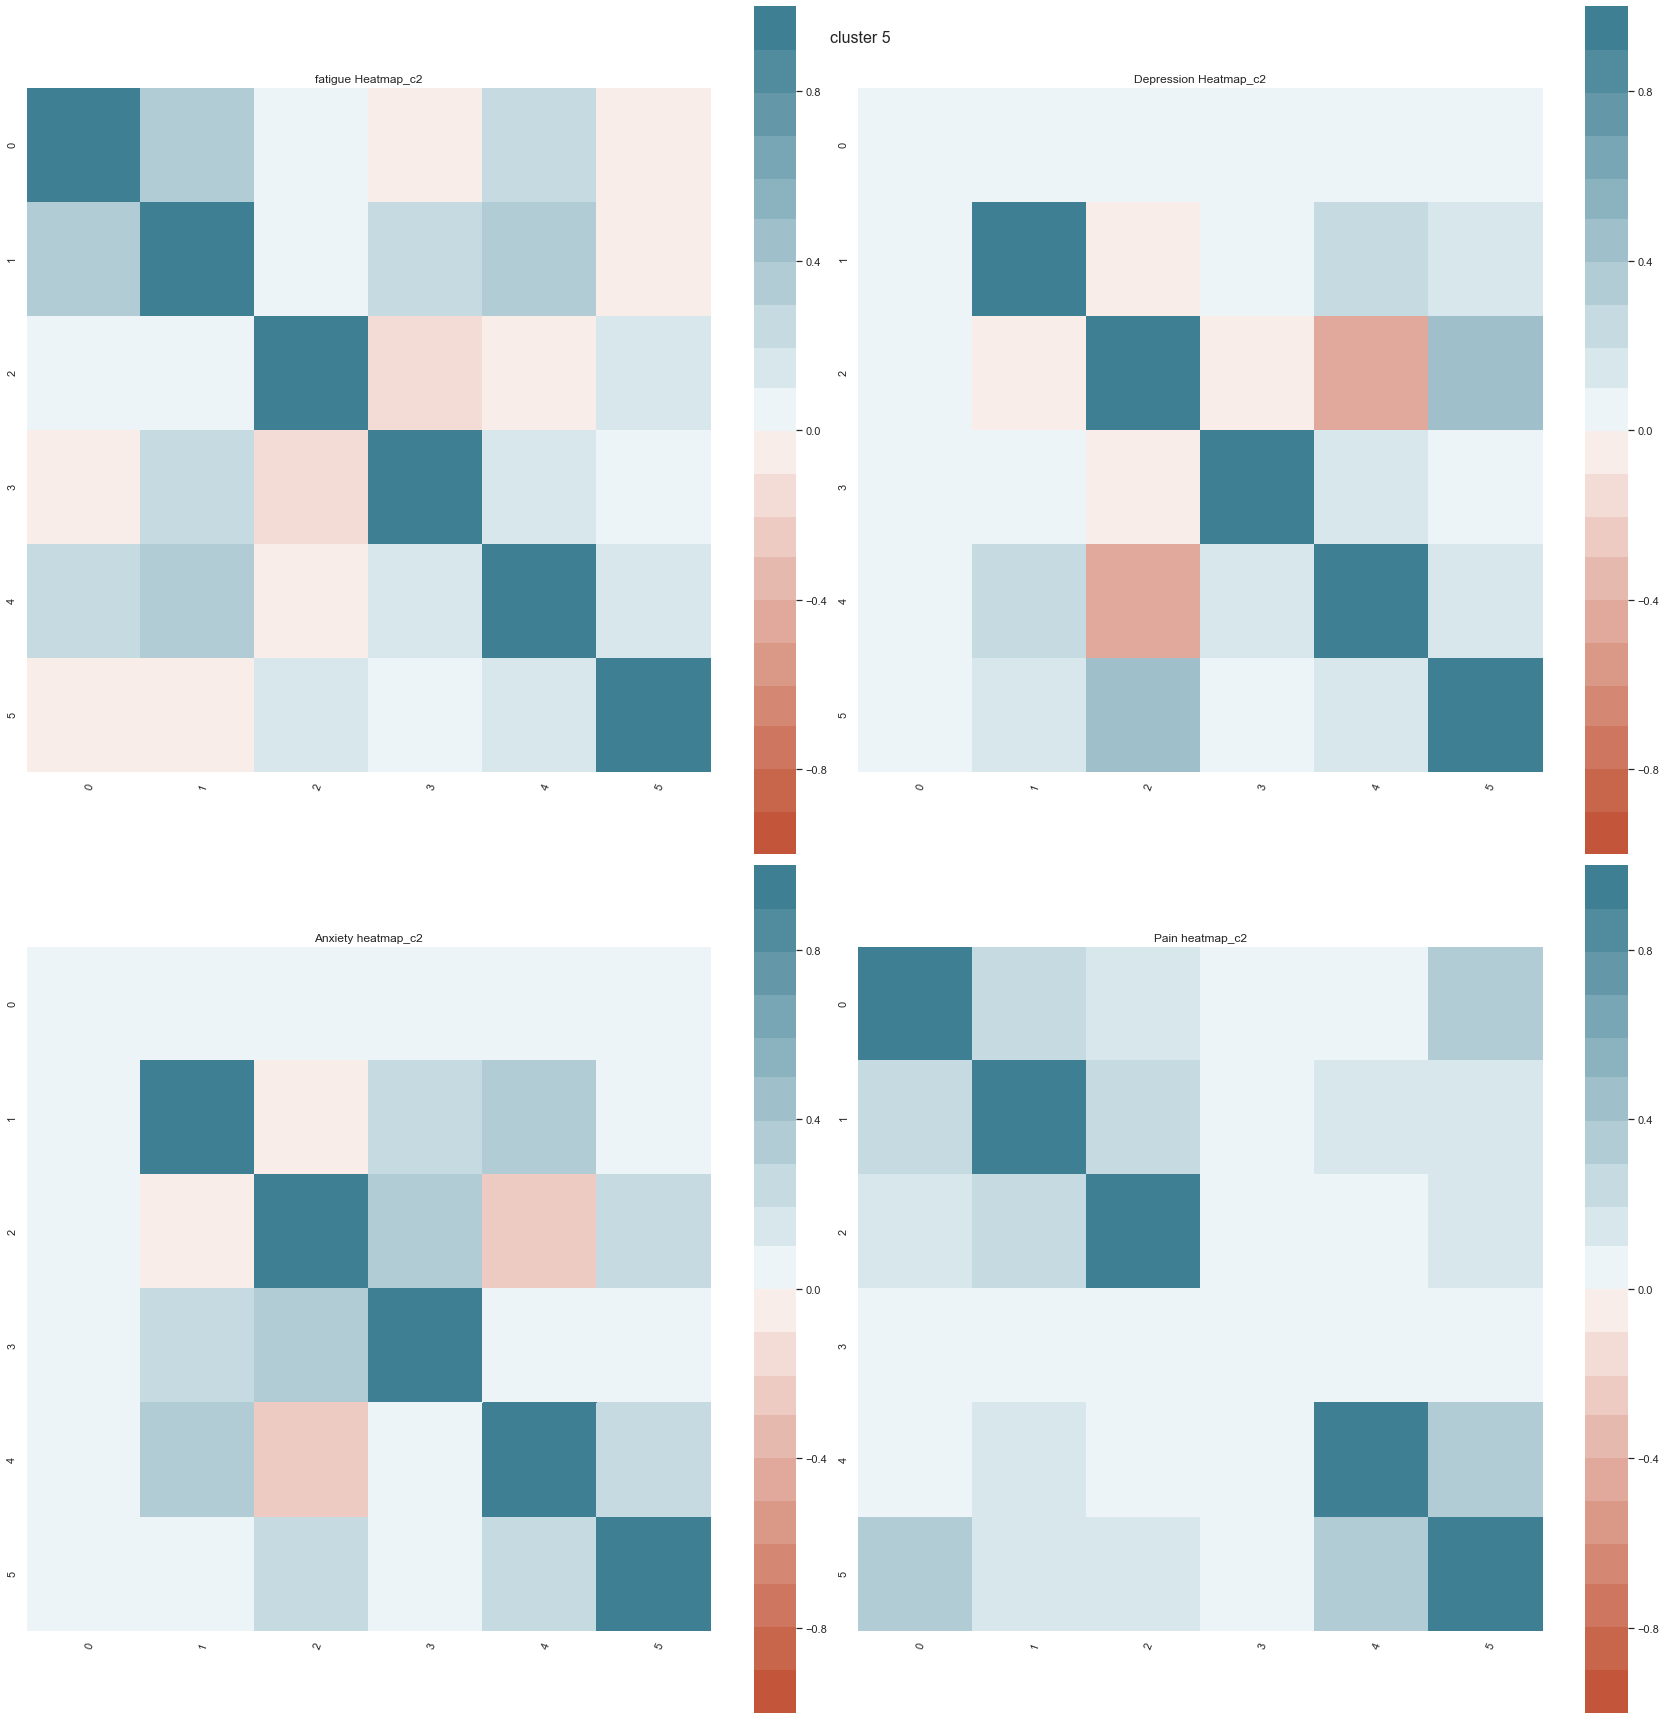

In [33]:
plt.suptitle("cluster 5", fontsize=16)
heatmap_subplot(5)

In [34]:
#Cat_id - 0 = fatigue, 1 = depression, 2 = anxiety, 3 = pain
def corr_martix_total(cat_id):
    SubjectData =  np.array(list(zip(UniqueNames,X)))
    SubjectInCluster = []
    subjects = []
    for key in DataFrameDict.keys():
        for i in DataFrameDict[key]:
            for j in range(len(SubjectData)):
                if i == SubjectData[j][0]:
                    subjects.append(i)
                    SubjectInCluster.append(SubjectData[j][1])

    traj_count = len(SubjectInCluster)
    corr_matrix = np.zeros((traj_count, traj_count))

    for i in range(0, traj_count):
        for j in range(i + 1, traj_count):
            corr = corr_dist_1d(SubjectInCluster[i][cat_id], SubjectInCluster[j][cat_id])
            corr_matrix[i, j] = corr
            corr_matrix[j, i] = corr

    return corr_matrix

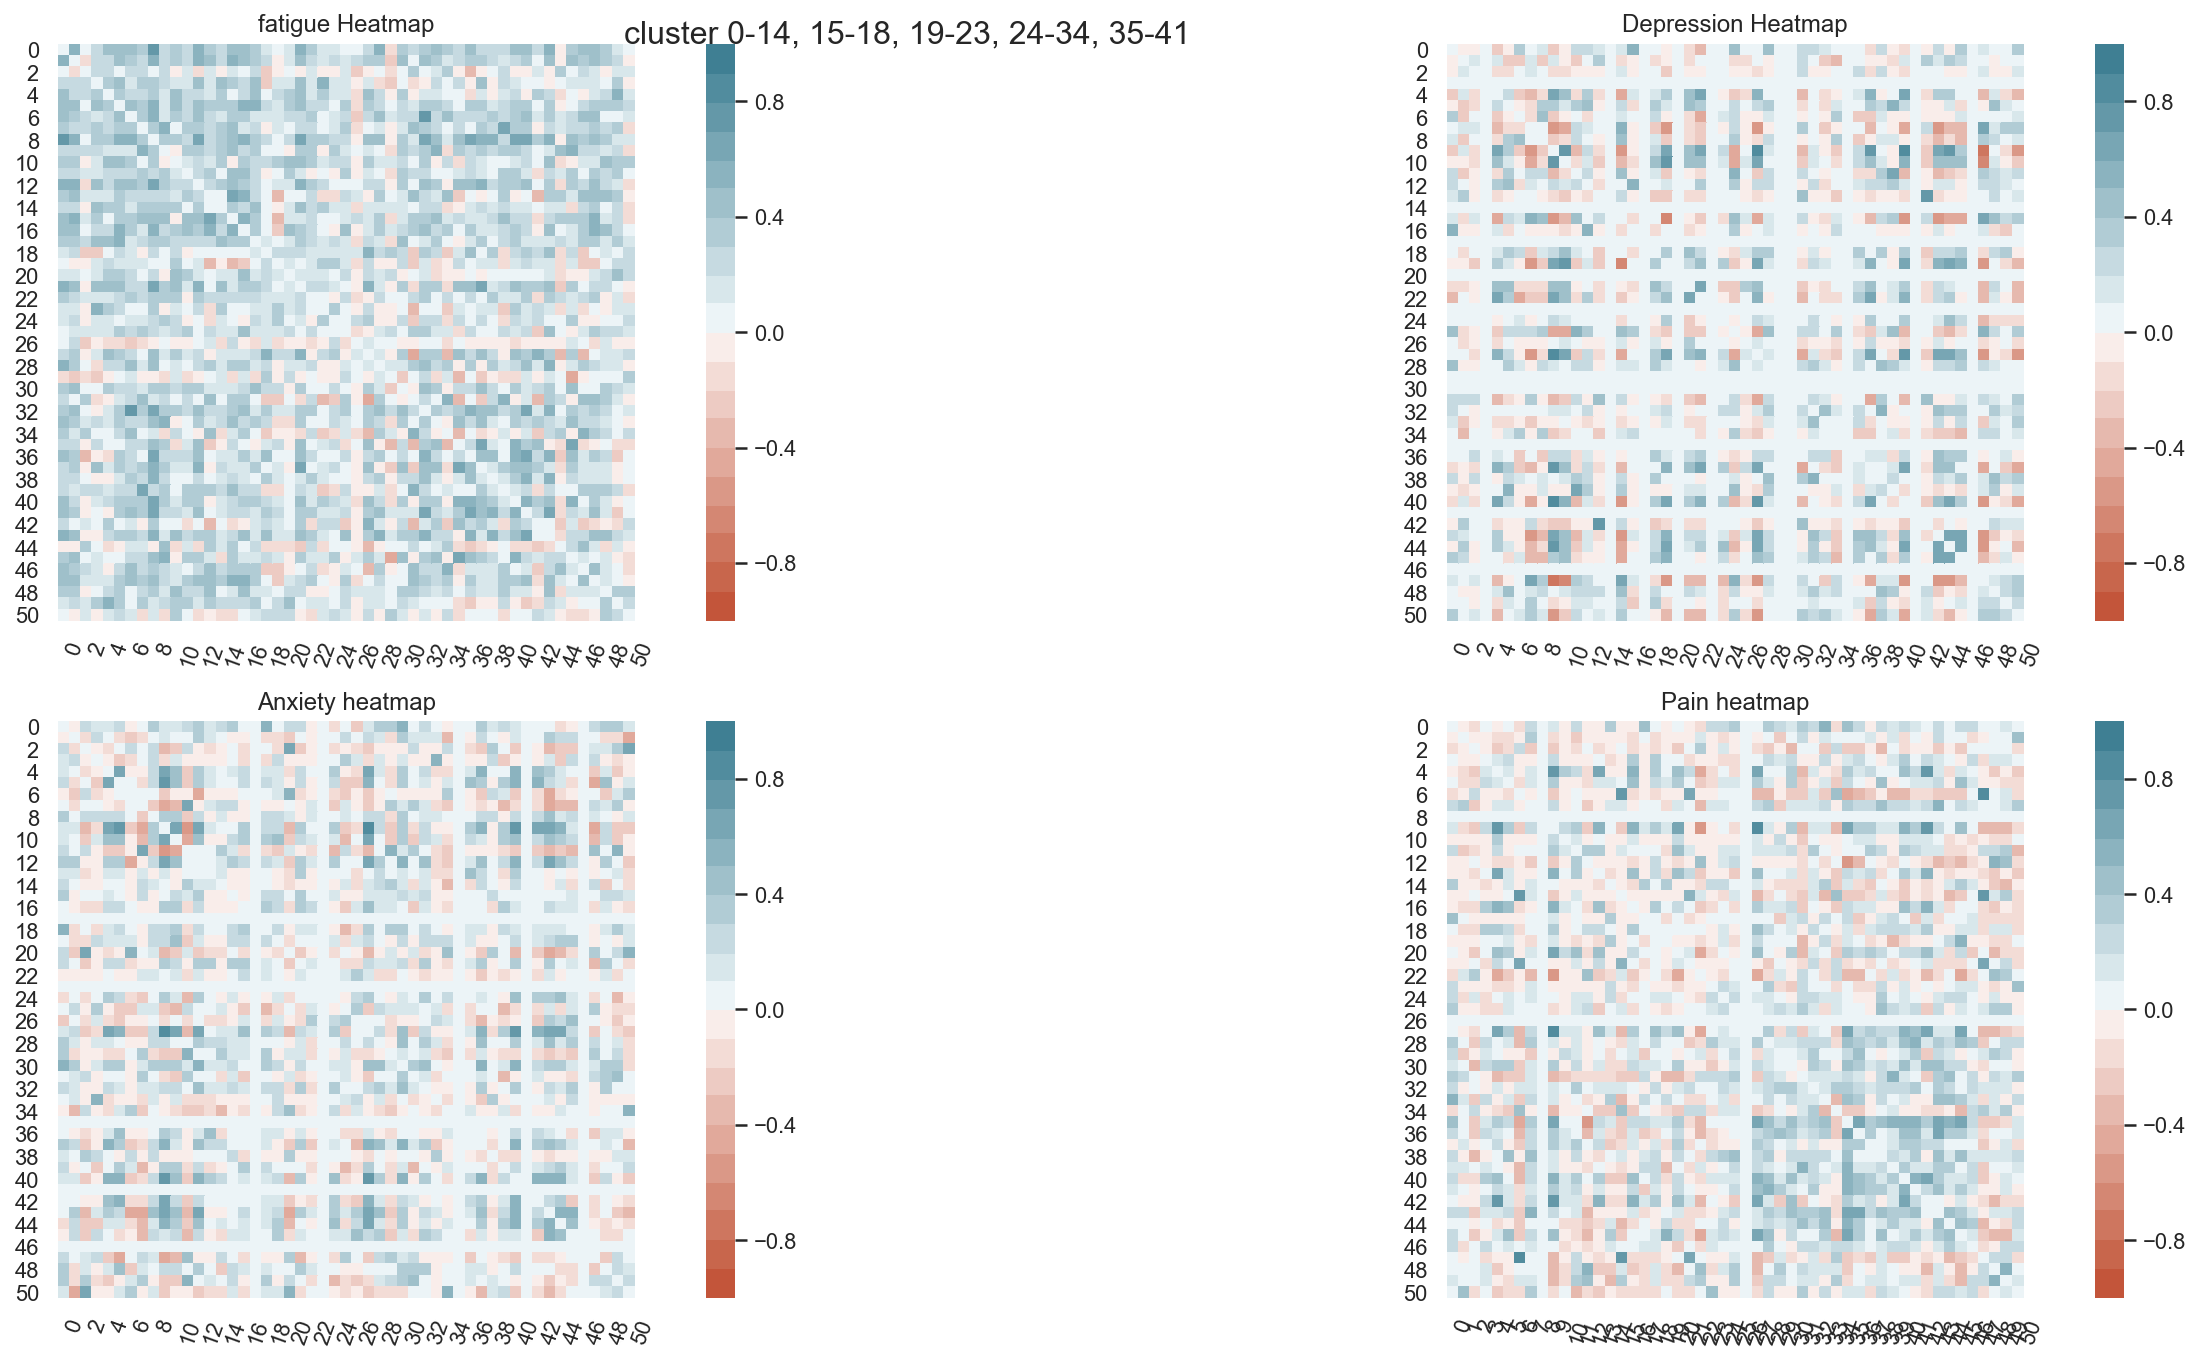

In [35]:
%matplotlib qt

plt.rcParams['figure.figsize'] = (24, 24)
xticks = np.arange(42+1)
plt.suptitle("cluster 0-14, 15-18, 19-23, 24-34, 35-41", fontsize=16)

plt.subplot(2, 2, 1)
heatmap(corr_martix_total(0),'fatigue Heatmap')
plt.subplot(2, 2, 2)
heatmap(corr_martix_total(1),'Depression Heatmap')
plt.subplot(2, 2, 3)
heatmap(corr_martix_total(2),'Anxiety heatmap')
plt.subplot(2, 2, 4)
heatmap(corr_martix_total(3),'Pain heatmap')

In [36]:
def typical_patient(cat_id):

    SubjectData =  np.array(list(zip(UniqueNames,X)))
    #subjects = []
    typical_patient = []
    for key in DataFrameDict.keys():
        SubjectsInCluster = []
        for i in DataFrameDict[key]:
            for j in range(len(SubjectData)):
                if i == SubjectData[j][0]:
                    #subjects.append(i)
                    SubjectsInCluster.append(SubjectData[j][1])
        typical_patient.append(np.array(np.sum(SubjectsInCluster, axis = 0))/len(SubjectsInCluster))

    traj_count = len(typical_patient)
    corr_matrix = np.zeros((traj_count, traj_count))

    for i in range(0, traj_count):
        for j in range(i + 1, traj_count):
            corr = corr_dist_1d(typical_patient[i][cat_id], typical_patient[j][cat_id])
            corr_matrix[i, j] = corr
            corr_matrix[j, i] = corr

    return corr_matrix

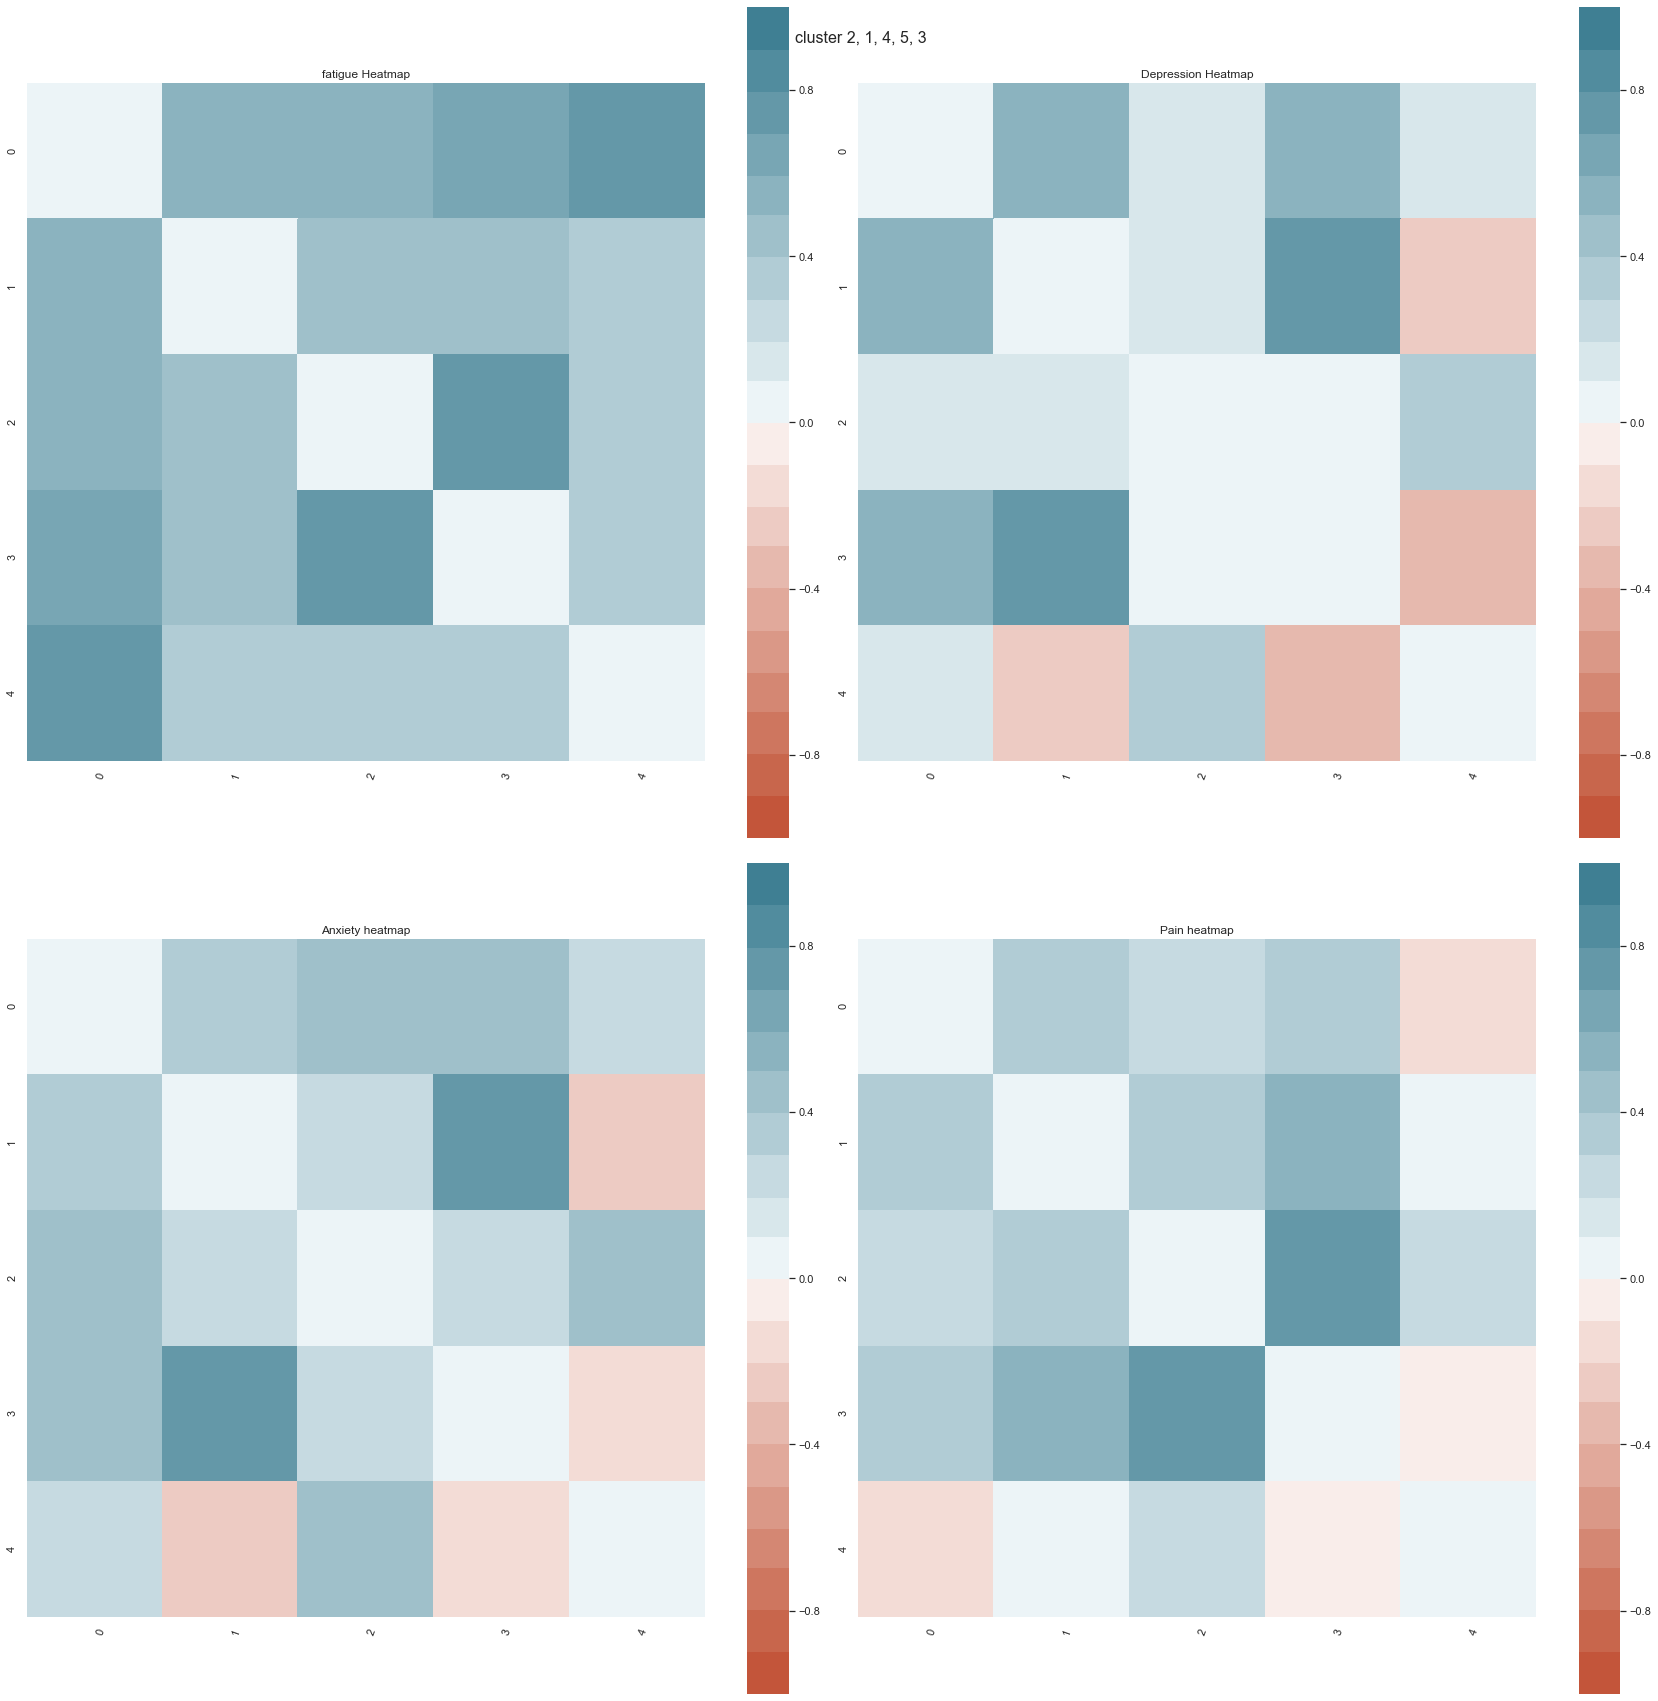

In [37]:
%matplotlib inline

plt.rcParams['figure.figsize'] = (24, 24)
#xticks = np.arange(42+1)
plt.suptitle("cluster 2, 1, 4, 5, 3", fontsize=16)

plt.subplot(2, 2, 1)
heatmap(typical_patient(0),'fatigue Heatmap')
plt.subplot(2, 2, 2)
heatmap(typical_patient(1),'Depression Heatmap')
plt.subplot(2, 2, 3)
heatmap(typical_patient(2),'Anxiety heatmap')
plt.subplot(2, 2, 4)
heatmap(typical_patient(3),'Pain heatmap')

In [38]:
typical_patient(0)

array([[0.000, 0.588, 0.589, 0.662, 0.715],
       [0.588, 0.000, 0.477, 0.488, 0.367],
       [0.589, 0.477, 0.000, 0.696, 0.354],
       [0.662, 0.488, 0.696, 0.000, 0.303],
       [0.715, 0.367, 0.354, 0.303, 0.000]])

In [39]:
(time.time() - t1)/60

14.693026864528656